In [226]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.formula.api as smf

In [227]:
target_columns = [
    'category', 
    'main_category', 
    'currency', 
    'deadline', 
    'goal', 
    'launched', 
    'pledged', 
    'state', 
    'backers', 
    'country'
]

df1 = pd.read_csv("ks-projects-201612.csv", encoding = "ISO-8859-1")

# original column names have extra spaces at the end, let's remove these spaces
for cn in df1.columns:
    df1.rename(columns={cn: cn.strip()}, inplace=True)
#print(df1.columns)

# select only defined columns
df1 = df1[target_columns]
df1['origin'] = 'df1'

df1.columns

Index(['category', 'main_category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'state', 'backers', 'country', 'origin'],
      dtype='object')

In [228]:
df2 = pd.read_csv("ks-projects-201801.csv")

# select only defined columns
df2 = df2[target_columns]
df2['origin'] = 'df2'

df2.columns

Index(['category', 'main_category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'state', 'backers', 'country', 'origin'],
      dtype='object')

In [229]:
# merge two datasets into one
df = pd.concat([df1, df2], ignore_index=True)
print(df.columns)

Index(['category', 'main_category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'state', 'backers', 'country', 'origin'],
      dtype='object')


In [230]:
# cleanup rows with invalid backers values
indexes = df[pd.to_numeric(df['backers'], errors='coerce').isnull()].index
df.drop(indexes, inplace=True)

# convert retained backers to int
df['backers'] = pd.to_numeric(df['backers']).round(0)
df.count()
#pd.value_counts(df['backers'])

category         701788
main_category    701788
currency         701788
deadline         701788
goal             701788
launched         701788
pledged          701788
state            701788
backers          701788
country          701788
origin           701788
dtype: int64

In [231]:
#print(pd.value_counts(df['state']))

states = ('failed', 'suspended', 'canceled', 'undefined', 'live', 'successful')

# clean up data with invalid 'state' values
indexes = df[~df['state'].isin(states)].index
df.drop(indexes, inplace=True)

pd.value_counts(df['state'])

failed        365940
successful    247037
canceled       71133
live            7227
undefined       7117
suspended       3325
Name: state, dtype: int64

In [232]:
print(df['state'].unique())

df['state_new'] = df['state'].apply(lambda s: states.index(s))

categories = list(df['main_category'].unique())
categories.sort()
df['main_category_new'] = df['main_category'].apply(lambda s: categories.index(s))

countries = list(df['country'].unique())
countries.sort()
#print(countries)
df['country_new'] = df['country'].apply(lambda s: countries.index(s))

df['pledged'] = pd.to_numeric(df['pledged'])
df['goal'] = pd.to_numeric(df['goal'])
df['profit_ratio'] = df['pledged'] / df['goal']

df['duration'] = (pd.to_datetime(df['deadline']) - pd.to_datetime(df['launched'])).dt.days

#df.head()

['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']


In [233]:
df.drop_duplicates(keep=False, inplace=True)

# TODO: check country code for two-letter instead
indexes = df[df['country'].isin(['N,0"', 'N,"0'])].index
df.drop(indexes, inplace=True)

# export data for analysis
df.to_csv('my_ks-projects-merged.csv')

df.count()

category             694192
main_category        694192
currency             694192
deadline             694192
goal                 694192
launched             694192
pledged              694192
state                694192
backers              694192
country              694192
origin               694192
state_new            694192
main_category_new    694192
country_new          694192
profit_ratio         694192
duration             694192
dtype: int64

In [238]:
success_df = df.loc[df['state'] == "successful"]
success_df.corr()

#df.corr()

,goal,pledged,backers,state_new,main_category_new,country_new,profit_ratio,duration
goal,1.000000,0.505244,0.452175,NaN,0.022165,0.000340,-0.004442,0.054839
pledged,0.505244,1.000000,0.728704,NaN,0.011716,0.001560,0.007136,0.032671
backers,0.452175,0.728704,1.000000,NaN,0.006153,0.005329,0.015234,0.022658
state_new,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
main_category_new,0.022165,0.011716,0.006153,NaN,1.000000,0.011007,0.002261,0.043463
country_new,0.000340,0.001560,0.005329,NaN,0.011007,1.000000,0.004321,0.038407
profit_ratio,-0.004442,0.007136,0.015234,NaN,0.002261,0.004321,1.000000,0.005527
duration,0.054839,0.032671,0.022658,NaN,0.043463,0.038407,0.005527,1.000000


In [235]:
result = smf.ols('state_new ~ pledged + backers + goal + main_category_new + country_new + duration', data=df).fit()
#result = smf.ols('state_new ~ pledged + backers', data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              state_new   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2278.
Date:                Fri, 01 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:01:34   Log-Likelihood:            -1.5606e+06
No. Observations:              694192   AIC:                         3.121e+06
Df Residuals:                  694185   BIC:                         3.121e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.7798      0.010    171.829      0.000       1.759       1.800
pledged             9.78e-07   4.31e-08     22.684      0.000    8.93e-07    1.06e-06
backers               0.0002   4.35e-06     52.320      0.000       0.000       0.000
goal              -4.398e-08   2.35e-09    -18.706      0.000   -4.86e-08   -3.94e-08
main_category_new    -0.0150      0.001    -21.336      0.000      -0.016      -0.014
country_new           0.0179      0.000     42.654      0.000       0.017       0.019
duration             -0.0007      4e-05    -16.850      0.000      -0.001      -0.001
==============================================================================
Omnibus:                     9810.362   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10233.126
Skew:                           0.297   Prob(JB):                         0.00
Kurtosis:                       3.003   Cond. No.                     4.41e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

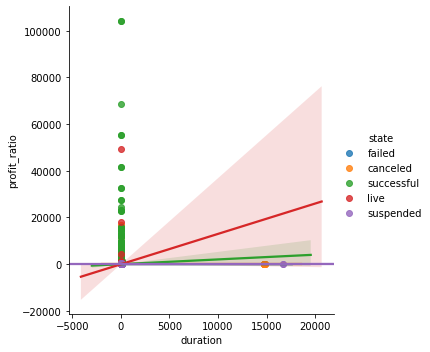

In [248]:
sns.lmplot(x='duration', y='profit_ratio', data=df,
          fit_reg=True,
          hue="state")